# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 1.10.2021

Мягкий дедлайн: 17.10.2021 23:59 МСК

Жесткий дедлайн: 24.10.2021 23:59 МСК (1 неделя -- минус балл)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Загрузите решение в свой репозиторий на github и поделитесь [ссылкой на решение в форме](https://forms.gle/ZzCaqRj6bmfpSpyL7). Не забудьте дать доступ к Вашему репозиторию, что у преподавателей была возмоожность проверить работу.

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [408]:
#!c1.8
import random

import numpy as np
import scipy
from scipy.stats import chi
from itertools import combinations

from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
#!g1.1
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

Using TensorFlow backend.


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [409]:
#!c1.8
from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin): 
    """
    При унаследовании от TransformerMixin, fit_transformer() можно не задавать, 
    Если добавить в качестве базового класса BaseEstimator и не реализовывать *args, **kwargs в конструкторе,
    то будут доступны методы get_params() и set_params()
    """
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.normalizer = Normalizer()
        self.new_dim = new_dim
        self.PCA_model = PCA(new_dim)
        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression(max_iter = 500, n_jobs = -1, random_state = 72)
        else:
            self.model = SVC(kernel='linear', random_state = 72)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            X = self.PCA_model.fit_transform(X, y)
            print('PCA применён')
            
        elements_for_choosing = random.sample(range(X.shape[0]), 1420) # выбираю случ. элементы из выборки для составления пар
        
        dist_list = [] # список пар
        for (c,p) in combinations(elements_for_choosing, 2): # составляю комбинации пар выборки
            dist_list.append(list(scipy.spatial.distance.cdist(X[c].reshape(1,-1), 
                                                               X[p].reshape(1,-1),
                                                               lambda u, v: ((u-v)**2).sum())[0]))
        self.median = np.median(dist_list) # рассчитываю медиану
        print('Медиана посчитана: {:.5f}'.format(self.median))
        self.w = np.random.normal(scale=1./self.median, size=(X.shape[1], self.n_features)) # генерирую набор весов
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features) # генерирую набор свдигов
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        self.model.fit(new_features_X, y)
        return
    
    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.PCA_model.transform(X)
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        return self.model.predict_proba(new_features_X)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.PCA_model.transform(X)
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        return self.model.predict(new_features_X)

In [351]:
#!g1.1
rffp_kernel = RFFPipeline()
rffp_kernel.fit(x_train, y_train)

preds = rffp_kernel.predict(x_test)
print('Доля верных ответов на тестовой выборке:', accuracy_score(preds, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA применён
Медиана посчитана: 0.62363
Доля верных ответов на тестовой выборке: 0.8888666666666667


In [354]:
#!g1.1
# Применение модели с другими параметрами:
rffp_kernel = RFFPipeline(n_features=3000, use_PCA=False, classifier='svm')
rffp_kernel.fit(x_train, y_train)

preds = rffp_kernel.predict(x_test)
print('Доля верных ответов на тестовой выборке:', accuracy_score(preds, y_test))

Доля верных ответов на тестовой выборке: 0.8679


In [355]:
#!g1.1
# Применение модели с другими параметрами:
rffp_kernel = RFFPipeline(n_features=500, new_dim=40)
rffp_kernel.fit(x_train, y_train)
preds = rffp_kernel.predict(x_test)
print('Доля верных ответов на тестовой выборке: {:.5f}'.format(accuracy_score(preds, y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


PCA применён
Медиана посчитана: 0.61542
Доля верных ответов на тестовой выборке: 0.85810


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [372]:
#!c1.8 # линеный SVM на случайных признаках
%%time
linear2_rffp_kernel = RFFPipeline(classifier='svm')
linear2_rffp_kernel.fit(x_train, y_train)
preds = linear2_rffp_kernel.predict(x_test)
print('Линеный SVM на случайных признаках. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(preds, y_test)))

PCA применён
Медиана посчитана: 0.63925
Линеный SVM на случайных признаках. Доля верных ответов на тестовой выборке: 0.88130

CPU times: user 17min 10s, sys: 21.8 s, total: 17min 32s
Wall time: 17min 14s


In [373]:
#!c1.8 # линеный SVM на случайных признаках
%%time
linear_rffp_kernel = RFFPipeline(n_features=3000, classifier='svm')
linear_rffp_kernel.fit(x_train, y_train)
preds = linear_rffp_kernel.predict(x_test)
print('Линеный SVM на случайных признаках. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(preds, y_test)))

PCA применён
Медиана посчитана: 0.62804
Линеный SVM на случайных признаках. Доля верных ответов на тестовой выборке: 0.88150

CPU times: user 48min 28s, sys: 24.1 s, total: 48min 52s
Wall time: 48min 34s


In [6]:
#!c1.8
# нормирую вектора
x_train_normed = Normalizer().fit_transform(x_train)
x_test_normed = Normalizer().transform(x_test)

In [370]:
#!c1.8 # линеный SVM на исходных признаках
%%time
linear_svm = SVC(kernel='linear')
linear_svm.fit(x_train_normed, y_train)
linear_preds = linear_svm.predict(x_test_normed)
print('Линеный SVM на исходных признаках. Доля верных ответов на тестовой выборке: {:.5f}'.format(accuracy_score(linear_preds, y_test)))

Линеный SVM на исходных признаках. Доля верных ответов на тестовой выборке: 0.85320
CPU times: user 14min 24s, sys: 1.27 s, total: 14min 25s
Wall time: 14min 36s


**Сравнение обучения SVM на случайных и исходных признаках**: Качество предсказаний SVM на исходных признаках ниже качества на случайных признаках. Однако на исходных признаках линейный SVM обучается гораздо быстрее. 

С увеличением числа случайных признаков, качество предсказаний увеличивается.

In [10]:
#!c1.8
# для применения нелинейного SVM на случайных признаках необходимо немного отредактировать класс



class RFFPipeline_New(BaseEstimator, TransformerMixin): 
    def __init__(self, model, n_features=1000, new_dim=50, use_PCA=True):
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.normalizer = Normalizer()
        self.new_dim = new_dim
        self.PCA_model = PCA(new_dim)
        self.model = model

    def fit(self, X, y):
        X = self.normalizer.fit_transform(X)
        if self.use_PCA:
            X = self.PCA_model.fit_transform(X, y)
            
        elements_for_choosing = random.sample(range(X.shape[0]), 1420) # выбираю случ. элементы из выборки для составления пар
        
        dist_list = [] # список пар
        for (c,p) in combinations(elements_for_choosing, 2): # составляю комбинации пар выборки
            dist_list.append(list(scipy.spatial.distance.cdist(X[c].reshape(1,-1), 
                                                               X[p].reshape(1,-1),
                                                               lambda u, v: ((u-v)**2).sum())[0]))
        self.median = np.median(dist_list) # рассчитываю медиану
        self.w = np.random.normal(scale=1./self.median, size=(X.shape[1], self.n_features)) # генерирую набор весов
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features) # генерирую набор свдигов
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        self.model.fit(new_features_X, y)
        return
    
    def predict_proba(self, X):
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.PCA_model.transform(X)
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        return self.model.predict_proba(new_features_X)
        
    def predict(self, X):
        X = self.normalizer.transform(X)
        if self.use_PCA:
            X = self.PCA_model.transform(X)
        
        new_features_X = np.cos(np.dot(X, self.w) + self.b)
        return self.model.predict(new_features_X)

In [11]:
#!c1.8 # SVM с rbf-ядром на случайных признаках
%%time
rbf_kernel = SVC(kernel='rbf', random_state = 72)
unlinear_rffp_kernel = RFFPipeline_New(model=rbf_kernel)
unlinear_rffp_kernel.fit(x_train, y_train)
rbf_preds = unlinear_rffp_kernel.predict(x_test)
print('SVM с rbf-ядром на случайных признаках. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(rbf_preds, y_test)))

SVM с rbf-ядром на случайных признаках. Доля верных ответов на тестовой выборке: 0.87500

CPU times: user 17min 52s, sys: 21.3 s, total: 18min 13s
Wall time: 17min 45s


In [378]:
#!c1.8 # SVM с rbf-ядром на случайных признаках
%%time
rbf_kernel = SVC(kernel='rbf')
unlinear_rffp_kernel = RFFPipeline_New(model=rbf_kernel, n_features=3000)
unlinear_rffp_kernel.fit(x_train, y_train)
rbf_preds = unlinear_rffp_kernel.predict(x_test)
print('SVM с rbf-ядром на случайных признаках. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(rbf_preds, y_test)))

SVM с rbf-ядром на случайных признаках. Доля верных ответов на тестовой выборке: 0.87450

CPU times: user 45min 56s, sys: 21.4 s, total: 46min 17s
Wall time: 45min 49s


In [377]:
#!c1.8 # SVM с rbf-ядром на исходных признаках
%%time
rbf_svm = SVC(kernel='rbf').fit(x_train_normed, y_train)
rbf2_preds = rbf_svm.predict(x_test_normed)
print('SVM с rbf-ядром на исходных признаках. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(rbf2_preds, y_test)))

SVM с rbf-ядром на исходных признаках. Доля верных ответов на тестовой выборке: 0.88400

CPU times: user 13min 50s, sys: 1.53 s, total: 13min 52s
Wall time: 14min 18s


In [379]:
#!c1.8
%%time
unlinear_rffp_kernel.fit(x_train, y_train)

CPU times: user 33min 18s, sys: 21.8 s, total: 33min 40s
Wall time: 33min 12s


In [381]:
#!c1.8
%%time
linear_rffp_kernel = RFFPipeline(n_features=3000, classifier='svm')
linear_rffp_kernel.fit(x_train, y_train)

PCA применён
Медиана посчитана: 0.63138
CPU times: user 37min 21s, sys: 28.2 s, total: 37min 50s
Wall time: 38min 2s


**Сравнение обучения ядрового и линейного SVM на случайных и исходных признаках:** На исходных признаках ядровой SVM показал качество лучше, чем линейный SVM. Качество оказалось даже лучше, чем у линейного SVM на случайных признаках.

**Сравнение обучения ядрового и линейного SVM:** Время обучения линейного SVM и ядрового на восьмиядерной машине не сильно разнится. SVM с rbf-ядром получилось обучить даже быстрее, чем линейный. Однако качество предсказаний SVM с rbf-ядром на случайных признаках получилось хуже, чем у линейного SVM.

#### Подбор числа деревьев и длины шага для LightGBM:

In [398]:
#!g1.1
# понижаю размерность для обучения Light-gbm
pca = PCA(n_components = 50)
x_train_pca = pca.fit_transform(x_train_normed, y_train)
x_test_pca = pca.transform(x_test_normed)

In [394]:
#!g1.1
lr = np.logspace(-4, 1, 10)
trees_number = [100, 200, 350]
tuned_parameters = {'num_iterations' : trees_number, 'learning_rate' : lr, 'device' : ['gpu']}

clf = GridSearchCV(lgbm.LGBMClassifier(), tuned_parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
clf.fit(x_train_pca, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 32.8min finished
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=Tru...
             iid='deprecated', n_jobs=-1,
             param_grid={'device': ['gpu'],
                         'learning_rate': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
   

In [399]:
#!g1.1
%%time
lgbm_clf = lgbm.LGBMClassifier(**clf.best_params_)
lgbm_clf.fit(x_train_pca, y_train)
lgbm_preds = lgbm_clf.predict(x_test_pca)
print('Light-gbm на исходных признаках с применением PCA. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(lgbm_preds, y_test)))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Light-gbm на исходных признаках с применением PCA. Доля верных ответов на тестовой выборке: 0.87880

CPU times: user 3min 37s, sys: 1min 27s, total: 5min 5s
Wall time: 1min 18s


**Сравнение обучения Light-GBM и SVM c применением PCA:** Light-GBM обучается существенного быстрее, чем ядровой и линейный SVM. Однако при применении PCA Light-GBM немного уступает SVM по качеству предсказаний.

Попробуем обучить Light-GBM на исходных признаках без применения PCA.

In [380]:
#!g1.1
# подбор параметров для light-gbm без PCA
lr = np.logspace(-4, 2, 11)
trees_number = [50, 100, 350]
tuned_parameters = {'num_iterations' : trees_number, 'learning_rate' : lr, 'device' : ['gpu']}

clf2 = GridSearchCV(lgbm.LGBMClassifier(), tuned_parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
clf2.fit(x_train_normed, y_train)
clf2.results_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 68.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 197.7min finished
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=Tru...
             iid='deprecated', n_jobs=-1,
             param_grid={'device': ['gpu'],
                         'learning_rate': array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
   

In [383]:
#!g1.1
clf2.best_params_

{'device': 'gpu', 'learning_rate': 0.21544346900318823, 'num_iterations': 350}

In [402]:
#!g1.1
%%time
lgbm_clf2 = lgbm.LGBMClassifier(device='gpu', learning_rate = 0.21544346900318823, num_iterations = 350)
lgbm_clf2.fit(x_train_normed, y_train)
lgbm_preds2 = lgbm_clf2.predict(x_test_normed)
print('Light-gbm на исходных признаках без PCA. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(lgbm_preds2, y_test)))

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Light-gbm на исходных признаках без PCA. Доля верных ответов на тестовой выборке: 0.91190

CPU times: user 25min 54s, sys: 1min 33s, total: 27min 27s
Wall time: 5min 7s


**Сравнение обучения Light-GBM и SVM на исходных признаках:** при использовании видео-карты Light-GBM существенно обгоняет SVM по времени. Благодаря обучению Light-GBM на всём множестве признаков без применения PCA, удалось добиться лучшего результата из всех моделей.

**Итоговый вывод по всему заданию:** При обучении моделей на случайных признаках удалось добиться лучшего качества, чем на исходных, за исключением ядрового SVM на случайных признаках. Там качество ниже, поскольку ядровой метод применяется по сути дважды: сначала при апроксимации ядра, а потом и при обучении/предсказании. Light-GBM на исходных признаках показывает результаты лучше, чем SVM как для случайных признаков, так и для исходных, а также обошёл ядровой SVM на обоих видах признаков. Кроме этого, Light-GBM существенного обогнал по времени все рассмотренные ранее в этом задании алгоритмы. Таким образом, **с точки зрения эффективности применения на практике на имеющемся датасете целесообразно использовать Light-GBM.** Но, возможно, на других датасетах Light-GBM покажет качество ниже, чем ядровой SVM или SVM на случайных признаках. Кроме всего прочего, следует учитывать время на подбор гиперпараметров для Light-GBM. Если его принимать в расчёт, то SVM уже будет обгонять по времени Light-GBM.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

В предыдущем задании я провёл эксперименты, показывающие, что для Light-GBM понижение размерности оказывает негативное влияние на качество предсказаний, но при этом сокращается время обучения.

In [405]:
#!c1.8
%%time
linear_kernel_without_pca = RFFPipeline(use_PCA=False, classifier='svm')
linear_kernel_without_pca.fit(x_train, y_train)
linear_preds_without_pca = linear_kernel_without_pca.predict(x_test)
print('Линейный SVM на случайных признаках без PCA. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(linear_preds_without_pca, y_test)))

Медиана посчитана: 0.79452
Линейный SVM на случайных признаках без PCA. Доля верных ответов на тестовой выборке: 0.85750

CPU times: user 22min 7s, sys: 5.81 s, total: 22min 13s
Wall time: 22min 15s


In [12]:
#!c1.8
%%time
rbf_kernel = SVC(kernel='rbf', random_state=72)
unlinear_kernel_without_pca = RFFPipeline_New(model=rbf_kernel, use_PCA=False)
unlinear_kernel_without_pca.fit(x_train, y_train)
rbf_preds_without_pca = unlinear_kernel_without_pca.predict(x_test)
print('SVM с rbf-ядром на случайных признаках без PCA. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(rbf_preds_without_pca, y_test)))

SVM с rbf-ядром на случайных признаках без PCA. Доля верных ответов на тестовой выборке: 0.88000

CPU times: user 19min 24s, sys: 4.26 s, total: 19min 28s
Wall time: 19min 22s


In [7]:
#!c1.8
%%time
logreg_kernel = RFFPipeline(use_PCA=False, classifier='logreg')
logreg_kernel.fit(x_train, y_train)
logreg_preds = logreg_kernel.predict(x_test)
print('Логистическая регрессия на случайных признаках без PCA. Доля верных ответов на тестовой выборке: {:.5f}\n'.format(accuracy_score(logreg_preds, y_test)))

Медиана посчитана: 0.78339
Логистическая регрессия на случайных признаках без PCA. Доля верных ответов на тестовой выборке: 0.86020

CPU times: user 26 s, sys: 3.36 s, total: 29.4 s
Wall time: 8min 28s


In [407]:
#!c1.8
%%time
rffp_kernel = RFFPipeline()
rffp_kernel.fit(x_train, y_train)
preds = rffp_kernel.predict(x_test)
print('Доля верных ответов на тестовой выборке:', accuracy_score(preds, y_test))

PCA применён
Медиана посчитана: 0.63014
Доля верных ответов на тестовой выборке: 0.879
CPU times: user 35.6 s, sys: 22.1 s, total: 57.7 s
Wall time: 9min


**Вопрос:** Помогает ли предварительное понижение размерности с помощью PCA?

**Ответ:** Для разных моделей получились разные результаты, отменив понижение размерности для случайных признаков. Убрав понижение размерности исходного пространства признаков для логистической регрессии, качество предсказаний упало, время обучения увеличилось, но не на много. Для линейного SVM без PCA качество заметно упало по сравнению с вариантом с PCA, а время обучения тоже только увеличилось. Для ядрового SVM на случайных признаках, убрав понижение размерности, качество возросло, но и время обучения также увеличилось. В [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf) имперически показывается, что для успешного применения Random Fourier Features размерность нового пространства признаков должна быть больше размерности исходного пространства. До какого-то n_features чем оно больше, тем меньше ошибка апроксимации ядра для линейного SVM и логистической регрессии за счёт большего количество возможных приближений.

In [406]:
#!c1.8
features_num = [350, 700, 1000, 1300, 1500, 2000, 2500, 3000, 3500]

svm_acc = []
for features in features_num:
    linear2_rffp_kernel = RFFPipeline(n_features = features, classifier='svm')
    linear2_rffp_kernel.fit(x_train, y_train)
    preds = linear2_rffp_kernel.predict(x_test)
    print('\n', features, accuracy_score(preds, y_test))
    svm_acc.append(accuracy_score(preds, y_test))

PCA применён
Медиана посчитана: 0.62938

 350 0.8684
PCA применён
Медиана посчитана: 0.64287

 700 0.8795
PCA применён
Медиана посчитана: 0.63745

 1000 0.8796
PCA применён
Медиана посчитана: 0.64292

 1300 0.8809
PCA применён
Медиана посчитана: 0.63459

 1500 0.8842
PCA применён
Медиана посчитана: 0.62395

 2000 0.8841
PCA применён
Медиана посчитана: 0.63799

 2500 0.8867
PCA применён
Медиана посчитана: 0.61757

 3000 0.8818
PCA применён
Медиана посчитана: 0.63814

 3500 0.8837


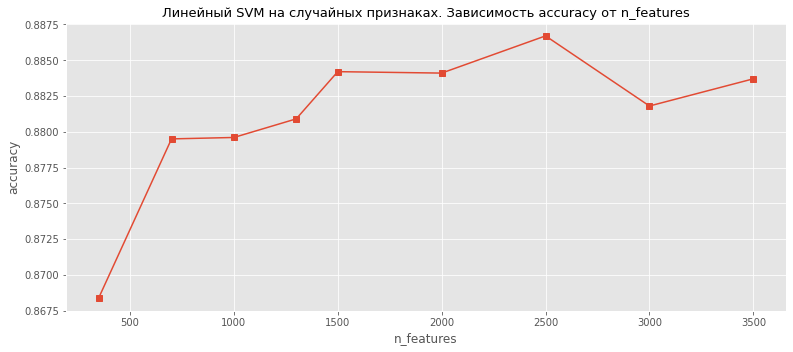

In [410]:
#!c1.8
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,4))
axes = fig.add_axes([0, 0, 1, 1])

axes.plot(features_num, svm_acc, "s-")
axes.set_title('Линейный SVM на случайных признаках. Зависимость accuracy от n_features', size=13)
axes.set_xlabel('n_features')
axes.set_ylabel('accuracy')
plt.show()

In [411]:
#!c1.8
acc_array = []
for features in features_num:
    linear2_rffp_kernel = RFFPipeline(n_features = features, classifier='logreg')
    linear2_rffp_kernel.fit(x_train, y_train)
    preds = linear2_rffp_kernel.predict(x_test)
    print('\n', features, accuracy_score(preds, y_test))
    acc_array.append(accuracy_score(preds, y_test))

PCA применён
Медиана посчитана: 0.62931

 350 0.8665
PCA применён
Медиана посчитана: 0.62891

 700 0.8778
PCA применён
Медиана посчитана: 0.62971

 1000 0.8799
PCA применён
Медиана посчитана: 0.62764

 1300 0.8828
PCA применён
Медиана посчитана: 0.63464

 1500 0.8816
PCA применён
Медиана посчитана: 0.63550

 2000 0.8844
PCA применён
Медиана посчитана: 0.63278

 2500 0.8856
PCA применён
Медиана посчитана: 0.64107

 3000 0.8834
PCA применён
Медиана посчитана: 0.63708


KeyboardInterrupt: 

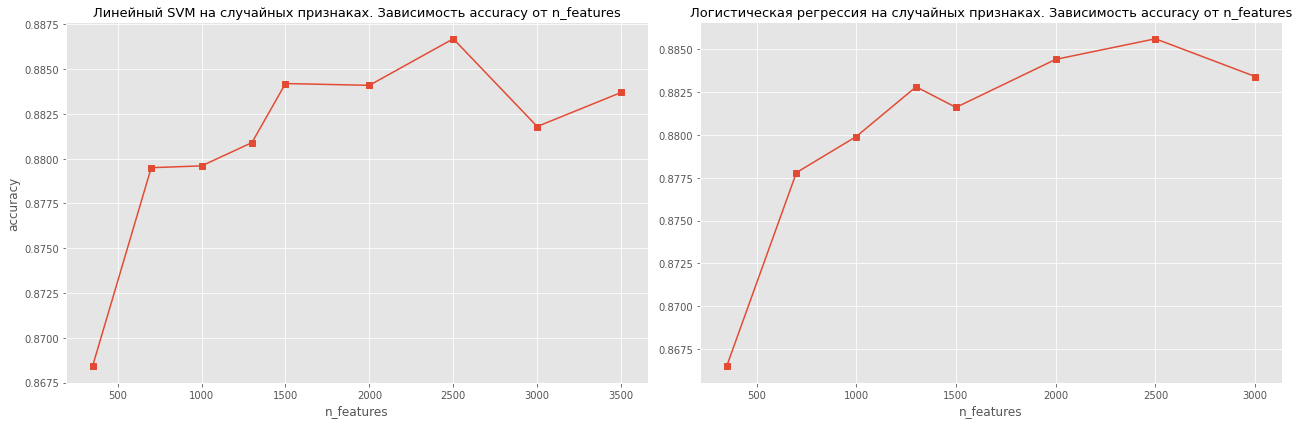

In [414]:
#!c1.8
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(18,6))

svm_acc = [0.8684, 0.8795, 0.8796, 0.8809, 0.8842, 0.8841, 0.8867, 0.8818, 0.8837] 

axes1.plot(features_num, svm_acc, "s-")
axes1.set_title('Линейный SVM на случайных признаках. Зависимость accuracy от n_features', size=13)
axes1.set_xlabel('n_features')
axes1.set_ylabel('accuracy')

axes2.plot(features_num[:-1], acc_array, "s-")
axes2.set_title('Логистическая регрессия на случайных признаках. Зависимость accuracy от n_features', size=13)
axes2.set_xlabel('n_features')
fig.tight_layout()

**Вопрос**: Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?

**Ответ:** С увеличением числа случайных признаков метрика качества также растёт. В [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf) сообщается, что при зафиксированном new_dim c ростом размерности случайных признаков (n_features) становится возможным добиться меньшей ошибки апроксимации. Можно сказать, что для линейного SVM при n_features > 1500 качество едва ли увеличивается, а выходит на плато. На графике для линейного SVM при n_features > 1500 можно видеть флуктуации значений accuracy даже при зафиксированном random_state модели. Это можно связать со случайностью инициализации самих весов и сдвигов, а также со случайностью выбора 1-го миллиона пар. Тем не менее, сильного роста метрики, как на первых шагах, не наблюдается.

Логистическая регрессия выходит на плато только при n_features = 2500.

**Вопрос:** Важно ли, какую модель обучать — логистическую регрессию или SVM?

**Ответ:** И линейный SVM и логистическая регрессия показывают сравнимо одинаковое качество предсказаний. При определённых конфигурациях модели SVM показывает качество чуть лучше, однако значительно дольше обучается, чем линейная регрессия. Таким образом, можно сделать вывод, что если качество до тысячных долей не играет особой роли, то лучше обучать логистическую регрессию, чтобы алгоритм отработал быстрее. Здесь также снова стоит отметить, что Light-GBM существенно обошёл все рассматриваемые модели как по качеству, так и по времени обучения.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪